# Overview
This project works on the Uniform Crime Reporting (UCR) Statistics in Houston. The UCR data contained in these reports, is presented in a monthly breakdown of Part I crimes for which HPD wrote police reports. The data is furthered broken down by police districts and beats and shows reports of the following types of crimes: murder, rape, robbery, aggravated assault, burglary, theft, auto theft. More information can be found in this [link](http://www.houstontx.gov/police/cs/index-2.htm). We use spreadsheets of the year 2010-2017 for our project.

We've cleaned the data and performed exploratory data analysis (EDA) in separate reports. According to the EDA, crimes are strongly correlated with time, locations and OffenseNum in a crime. In this project, we build machine learnig models to predict which type of crime is commited given those features as predictors.  

The data cleaning process can be found in this [report](https://github.com/phyhouhou/SpringboardProjects/blob/master/FirstCapstoneProject/data_cleaning_capstone_project.ipynb).<br>
The exploratory data analysis can be found in this [report](https://github.com/phyhouhou/SpringboardProjects/blob/master/FirstCapstoneProject/Exploratory_Data_Analysis_Capstone_Project.ipynb).



In [1]:
#Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

from pylab import *
rcParams['font.size'] = 18.0
rcParams['axes.titlesize'] = 20.0
rcParams['xtick.labelsize'] = 20.0
rcParams['legend.fontsize'] = 18.0

rcParams["figure.figsize"] = (15,9)

# Load data

In [2]:
crimes=pd.read_csv('./crimes_clean.csv',parse_dates=['Date'],index_col='Date')
crimes.head()

,Hour,OffenseType,Beat,Premise,BlockRange,StreetName,Type,Suffix,OffenseNum
Date,,,,,,,,,
2010-01-01,2,Theft,7C20,13,3100-3199,COLLINGSWORTH,-,-,1
2010-01-01,2,Robbery,20G70,18,1900-1999,WESTMEAD,DR,-,1
2010-01-01,9,Robbery,4F30,13,1700-1799,BRITTMOORE,RD,-,1
2010-01-01,10,Robbery,20G10,18,2900-2999,WEST SAM HOUSTON,PKWY,S,1
2010-01-01,14,Robbery,20G80,8,1000-1099,WEST OAKS MALL,-,-,1


In [3]:
crimes.info()
#no missing values

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 999521 entries, 2010-01-01 to 2017-12-31
Data columns (total 9 columns):
Hour           999521 non-null int64
OffenseType    999521 non-null object
Beat           999521 non-null object
Premise        999521 non-null int64
BlockRange     999521 non-null object
StreetName     999521 non-null object
Type           999521 non-null object
Suffix         999521 non-null object
OffenseNum     999521 non-null int64
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [4]:
ct=crimes.copy()
ct.Premise=ct.Premise.astype('str')
ct.select_dtypes(include='object').describe()

,OffenseType,Beat,Premise,BlockRange,StreetName,Type,Suffix
count,999521,999521,999521,999521,999521,999521,999521
unique,7,127,25,347,27780,35,5
top,Theft,19G10,20,100-199,WESTHEIMER,-,-
freq,549488,21299,316318,13738,27214,239896,861934


# Feature engineering
According to the [EDA](https://github.com/phyhouhou/SpringboardProjects/blob/master/FirstCapstoneProject/Exploratory_Data_Analysis_Capstone_Project.ipynb), there are 24 hour, 7 types of offense, 127 beats, 25 premises. Since some levels of the categorical features take only a small portion, we simplify the categories.

## Replace 'StreetName' and 'Type' by 'Address'

In [5]:
c=crimes.copy()
c['Address']=c['StreetName']+', '+c['Type']
c.drop(['BlockRange','StreetName','Type','Suffix'],axis=1,inplace=True)
c.head()

,Hour,OffenseType,Beat,Premise,OffenseNum,Address
Date,,,,,,
2010-01-01,2,Theft,7C20,13,1,"COLLINGSWORTH, -"
2010-01-01,2,Robbery,20G70,18,1,"WESTMEAD, DR"
2010-01-01,9,Robbery,4F30,13,1,"BRITTMOORE, RD"
2010-01-01,10,Robbery,20G10,18,1,"WEST SAM HOUSTON, PKWY"
2010-01-01,14,Robbery,20G80,8,1,"WEST OAKS MALL, -"


## Collaspe minority of beats into 'Other'

In [6]:
beat_count=c.Beat.value_counts()
threshold=beat_count.quantile(0.4)
blist=beat_count[beat_count<threshold].index.tolist()
rep={b:'Other' for b in blist}
c.Beat.replace(rep,inplace=True)
c.Beat=c.Beat.astype('category')
#len(c.Beat.value_counts())#-->77

## Collaspe minority of premises into 'Other'

In [7]:
premise_count=c.Premise.value_counts()
threshold=premise_count.quantile(0.3)
plist=premise_count[premise_count<threshold].index.tolist()
rep={p:'Other' for p in plist}
c.Premise.replace(rep,inplace=True)
c.Premise=c.Premise.astype('category')
#c.Premise.value_counts()


## Add 'Season', 'WeekDay'

In [9]:
# Convert months into season
sdict={'1':'win','2':'win','3':'spr','4':'spr','5':'spr','6':'sum','7':'sum','8':'sum','9':'aut','10':'aut','11':'aut','12':'win'}
c['Season']=c.index.month
c['Season']=c['Season'].astype(str).map(sdict).astype('category')

In [10]:
#convert days into weekday/weekend
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
wdict={i:'N' if i in ['Saturday','Sunday'] else 'Y' for i in days}

c.reset_index(inplace=True)
c['WeekDay']=c['Date'].dt.weekday_name.map(wdict).astype('category')

In [11]:
# Append 'am'/'pm' to 'hour'
hdict={str(i):str(i)+'am' if i<12 else str(i-12)+'pm' for i in range(0,24)}
hdict['12']='noon'
c['Hour']=c['Hour'].astype('str').map(hdict).astype('category')
c.head()

,Date,Hour,OffenseType,Beat,Premise,OffenseNum,Address,Season,WeekDay
0,2010-01-01,2am,Theft,7C20,13,1,"COLLINGSWORTH, -",win,Y
1,2010-01-01,2am,Robbery,20G70,18,1,"WESTMEAD, DR",win,Y
2,2010-01-01,9am,Robbery,4F30,13,1,"BRITTMOORE, RD",win,Y
3,2010-01-01,10am,Robbery,20G10,18,1,"WEST SAM HOUSTON, PKWY",win,Y
4,2010-01-01,2pm,Robbery,20G80,8,1,"WEST OAKS MALL, -",win,Y


In [12]:
c.set_index('Date',inplace=True)
c.OffenseType=c.OffenseType.astype('category')
c.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 999521 entries, 2010-01-01 to 2017-12-31
Data columns (total 8 columns):
Hour           999521 non-null category
OffenseType    999521 non-null category
Beat           999521 non-null category
Premise        999521 non-null category
OffenseNum     999521 non-null int64
Address        999521 non-null object
Season         999521 non-null category
WeekDay        999521 non-null category
dtypes: category(6), int64(1), object(1)
memory usage: 28.6+ MB


In [13]:
c.select_dtypes(exclude='int64').describe()

,Hour,OffenseType,Beat,Premise,Address,Season,WeekDay
count,999521,999521,999521,999521,999521,999521,999521
unique,24,7,77,18,31854,4,2
top,6pm,Theft,Other,20,"WESTHEIMER, RD",sum,Y
freq,56952,549488,121002,316318,26709,258887,729975


## About the target

The bar plot shows that this is an unbalanced multi-level classification. 'Theft' takes weight more than 50%, all the others in all takes less than 50% portion, i.e.,'Burglary' takes less than 20% while 'Murder' and 'Rape' takes only negligible part.

In [14]:
cols=[ 'OffenseType','Hour', 'Season','WeekDay','Beat', 'Premise', 'OffenseNum', 'Address' ]
crimes_data=c[cols]

X_crime = crimes_data.iloc[:, 1:]
y = crimes_data.iloc[:,0]
#Y_code= crimes_data.iloc[:,0].cat.codes
#dict(zip(Y,Y_code))

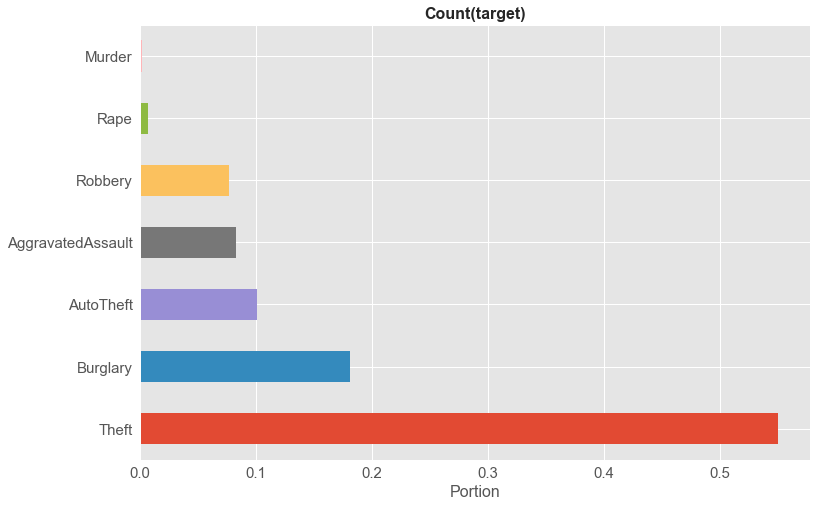

In [15]:
%matplotlib inline
plt.style.use('ggplot')
ax=y.value_counts(normalize=True).plot(kind='barh',rot=0,figsize=(12,8),fontsize=15);
ax.set_xlabel('Portion',fontsize=16)
ax.set_title('Count(target)',fontsize=16,fontweight='bold')
plt.savefig('figs/target.png');

## Preprocess categorical variables
We preprocess catagorical features by one hot encoding. That is to convert each category value into a new column and assigns a 1 or 0 value to the column.

In [16]:
obj_c=X_crime.select_dtypes(include=['object','category']).copy()
obj_c.columns

Index(['Hour', 'Season', 'WeekDay', 'Beat', 'Premise', 'Address'], dtype='object')

In [51]:
#onehotencoder by pd.get_dummies() is too slow due to many categorical features with multiple levels!!!
#pd.get_dummies(obj_c,columns=['Hour','Season', 'WeekDay', 'Beat', 'Premise','Address'],
#               prefix=['',''...]).head()#too slow more than 5min

Let's do label encoding for those features with levels more than 24.

In [17]:
obj_lab_col=['Beat','Address']
from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()

for col in obj_lab_col:
    data=X_crime[col]
    #le.fit(data.values)
    #X[col]=le.transform(X[col])
    X_crime[col]=le.fit_transform(X_crime[col])
#X_crime.head()    

Let's perform one hot encoding on remaining categorical columns.

In [18]:
obj_ohe_col=['Hour', 'Season', 'WeekDay','Premise']
ohe=pd.get_dummies(obj_c[obj_ohe_col], columns=obj_ohe_col, prefix=['H','S','W','P'],drop_first=True)
#ohe.head()

In [19]:
X=pd.concat([X_crime[obj_lab_col],X_crime['OffenseNum'],ohe],axis=1)
pd.set_option('display.max_columns', None)
X.head()

,Beat,Address,OffenseNum,H_10am,H_10pm,H_11am,H_11pm,H_1am,H_1pm,H_2am,H_2pm,H_3am,H_3pm,H_4am,H_4pm,H_5am,H_5pm,H_6am,H_6pm,H_7am,H_7pm,H_8am,H_8pm,H_9am,H_9pm,H_noon,S_spr,S_sum,S_win,W_Y,P_3,P_5,P_7,P_8,P_9,P_11,P_12,P_13,P_14,P_18,P_20,P_21,P_22,P_23,P_24,P_25,P_Other
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-01,69,6607,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2010-01-01,45,30418,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2010-01-01,57,4391,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2010-01-01,40,30205,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2010-01-01,46,30180,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


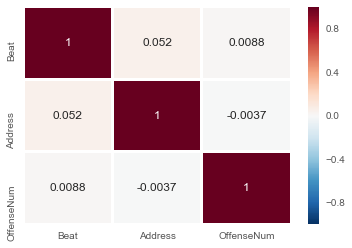

In [52]:
#X.corr()
corr=X[['Beat','Address','OffenseNum']].corr(method='spearman')
sns.heatmap(corr,annot=True,linewidths=2,annot_kws={'size':12});

This correlation matrix indicates that 'OffenseNum' is hardly correlated with 'Address' and 'Beat, which is reasonable; however, 'Address' and 'Beat' should expect larger correlation than shown in the matrix. This might due to improper label encoding. As indicated in DecisionTree classifier below, 'numerics' estimator plays important roles in feature selectin. How to solve this problem? Onehotencoding for a multi-level categorical estimator?  

How about remove 'Address' and onehotencoder all other categorical variables?

### Try to remove 'Address' and onehotencode categorical variables

In [20]:
# Remove 'Address' column
X_dropAdd = crimes_data.iloc[:, 1: -1]
obj_dropAdd=X_dropAdd.select_dtypes(include=['object','category']).copy()

# One hot encoding 
obj_ohedrop_col=obj_dropAdd.columns
ohe_dropAdd=pd.get_dummies(obj_dropAdd[obj_ohedrop_col], columns=obj_ohedrop_col, prefix=['H','S','W','B','P'],drop_first=True)

In [21]:
X_dropAdd=pd.concat([X_crime['OffenseNum'],ohe_dropAdd],axis=1)
pd.set_option('display.max_columns', None)
X_dropAdd.head()

,OffenseNum,H_10am,H_10pm,H_11am,H_11pm,H_1am,H_1pm,H_2am,H_2pm,H_3am,H_3pm,H_4am,H_4pm,H_5am,H_5pm,H_6am,H_6pm,H_7am,H_7pm,H_8am,H_8pm,H_9am,H_9pm,H_noon,S_spr,S_sum,S_win,W_Y,B_10H50,B_10H60,B_10H70,B_10H80,B_11H10,B_12D10,B_12D20,B_12D70,B_13D10,B_13D20,B_14D10,B_14D20,B_14D30,B_14D40,B_15E10,B_15E20,B_15E30,B_15E40,B_16E20,B_16E30,B_16E40,B_17E10,B_17E20,B_17E30,B_17E40,B_18F20,B_18F30,B_18F40,B_18F50,B_18F60,B_19G10,B_19G20,B_19G30,B_19G40,B_19G50,B_1A10,B_1A20,B_1A30,B_1A50,B_20G10,B_20G30,B_20G40,B_20G50,B_20G60,B_20G70,B_20G80,B_2A10,B_2A30,B_2A50,B_2A60,B_3B10,B_3B30,B_3B40,B_3B50,B_4F10,B_4F20,B_4F30,B_5F10,B_5F20,B_5F30,B_5F40,B_6B10,B_6B20,B_6B30,B_6B40,B_6B50,B_6B60,B_7C10,B_7C20,B_7C30,B_7C50,B_8C10,B_8C60,B_9C20,B_9C40,B_Other,P_3,P_5,P_7,P_8,P_9,P_11,P_12,P_13,P_14,P_18,P_20,P_21,P_22,P_23,P_24,P_25,P_Other
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-01,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2010-01-01,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2010-01-01,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2010-01-01,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2010-01-01,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
X_dropAdd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 999521 entries, 2010-01-01 to 2017-12-31
Columns: 121 entries, OffenseNum to P_Other
dtypes: int64(1), uint8(120)
memory usage: 149.6 MB


# Build Machine Learning Models

## Dummy classifier
Since this is a highly unbalanced classification, we use the dummy classifer to get a baseline. In the dummy classifier, we use the 'most_frequent' strategy, hence the classifer always predict dominant class 'Theft'.

In [23]:
from sklearn.model_selection import train_test_split

# default is 75% / 25% train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
from sklearn.dummy import DummyClassifier

dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)
y_dummy_predictions = dummy_majority.predict(X_test)

y_dummy_predictions

array(['Theft', 'Theft', 'Theft', ..., 'Theft', 'Theft', 'Theft'],
      dtype='<U5')

In [25]:
dumscore=dummy_majority.score(X_test, y_test)
print(dumscore)

0.5489452979618298


In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


# Other metrics
print("Confusion Matrix:\n", confusion_matrix(y_test, y_dummy_predictions))
print('\n')


print ("Accuracy : ", accuracy_score(y_test,y_dummy_predictions)*100)
print('\n')

print("Report :\n", classification_report(y_test,y_dummy_predictions))

dummycm=confusion_matrix(y_test, y_dummy_predictions)



Confusion Matrix:
 [[     0      0      0      0      0      0  20577]
 [     0      0      0      0      0      0  25384]
 [     0      0      0      0      0      0  45258]
 [     0      0      0      0      0      0    442]
 [     0      0      0      0      0      0   1730]
 [     0      0      0      0      0      0  19319]
 [     0      0      0      0      0      0 137171]]


Accuracy :  54.89452979618298




/Users/phyhouhou/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Report :
                    precision    recall  f1-score   support

AggravatedAssault       0.00      0.00      0.00     20577
        AutoTheft       0.00      0.00      0.00     25384
         Burglary       0.00      0.00      0.00     45258
           Murder       0.00      0.00      0.00       442
             Rape       0.00      0.00      0.00      1730
          Robbery       0.00      0.00      0.00     19319
            Theft       0.55      1.00      0.71    137171

      avg / total       0.30      0.55      0.39    249881



Drop 'Address' doesn't affect dummy classifier


## KNN classifier

In [27]:
#create classifer object
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors =20 )

#Train the classifier (fit the estimator) using the training data
knn.fit(X_train, y_train)

#Estimate the accuracy of the classifier on future data, using the test data
knnscore=knn.score(X_test, y_test)
print(knnscore)


0.577170733269036


In [59]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


# Other metrics
print("Confusion Matrix:\n", confusion_matrix(y_test, knn.predict(X_test)))
print ("Accuracy : ", accuracy_score(y_test,knn.predict(X_test))*100)
print("Report :\n", classification_report(y_test, knn.predict(X_test)))


Confusion Matrix:
 [[  1710    547   5712      0      3    736  11869]
 [   491   2069   2702      0      1    690  19431]
 [  1103    235  22332      0      1    233  21354]
 [    28     14    107      0      0     28    265]
 [    97     23    570      0      0     35   1005]
 [   732    966   2582      0      1   1673  13365]
 [  1704   2828  14860      0      2   1337 116440]]
Accuracy :  57.7170733269036
Report :
                    precision    recall  f1-score   support

AggravatedAssault       0.29      0.08      0.13     20577
        AutoTheft       0.31      0.08      0.13     25384
         Burglary       0.46      0.49      0.47     45258
           Murder       0.00      0.00      0.00       442
             Rape       0.00      0.00      0.00      1730
          Robbery       0.35      0.09      0.14     19319
            Theft       0.63      0.85      0.73    137171

      avg / total       0.51      0.58      0.52    249881



/Users/phyhouhou/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuray is increased compared to that of DummyClassifier and precision for crimes other than majority-class, i.e., 'Theft' gets better but still extreme minority-class like 'Murder' and 'Rape' can't be predicted.

### How sensitive is k-NN classification accuracy to the choice of the 'k' parameter?

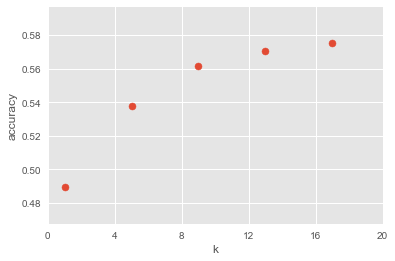

In [44]:
#calculate accuracy fed by different k's
k_range = range(1,20,4)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))

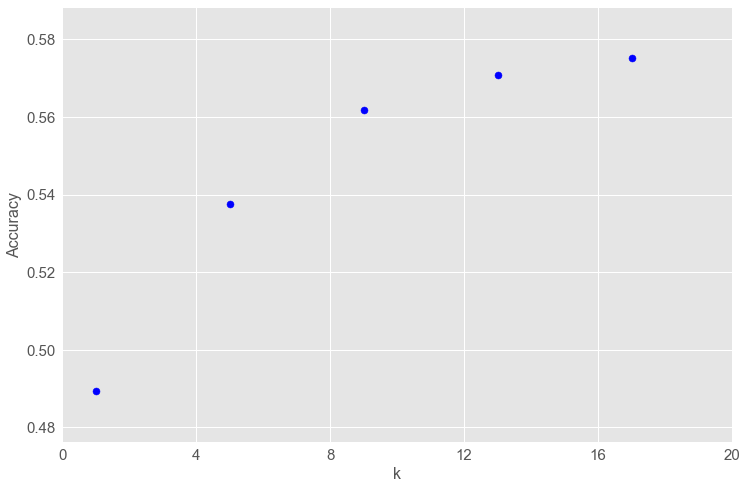

In [54]:
plt.figure(figsize=(12,8))
plt.xlabel('k',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.scatter(k_range, scores,color='blue')
plt.xticks([0,4,8,12,16,20],fontsize=15)
plt.yticks(fontsize=15);

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.neighbors import KNeighborsClassifier


# # default is 75% / 25% train-test split
# X_train, X_test, y_train, y_test = train_test_split(X_dropAdd, y, random_state=0)
# knn = KNeighborsClassifier(n_neighbors =20 )

# #Train the classifier (fit the estimator) using the training data
# knn.fit(X_train, y_train)

# #Estimate the accuracy of the classifier on future data, using the test data
# knn.score(X_test, y_test)

#Drop 'Address' and onehotencode other categoricals; it slows down KNN classifier a lot! Too slow!

## Decision tree, criterion = "gini"

In [29]:
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split( 
          X, y, test_size = 0.2, random_state = 0)

# Creating the classifier object
clf_gini = DecisionTreeClassifier(criterion = "gini",
            random_state = 0,max_depth=50, min_samples_leaf=3)
 
# Performing training
clf_object=clf_gini.fit(X_train, y_train)

# Prediction using gini
y_pred_gini = clf_object.predict(X_test)

dtscoregini=accuracy_score(y_test,y_pred_gini)
print(dtscoregini)


0.5285510617543333


In [30]:
#Other metrics
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gini))
print ("Accuracy : ", accuracy_score(y_test,y_pred_gini)*100)
print("Report :\n", classification_report(y_test, y_pred_gini))



Confusion Matrix:
 [[ 4350  1562  3364    10    49  1213  5876]
 [ 1951  3903  1900     3    17  1304 11246]
 [ 3540  1552 18885     2    62   705 11532]
 [   66    35    58     0     1    48   136]
 [  256    90   426     2    11    81   528]
 [ 2034  1916  1752     7    22  2400  7250]
 [ 6738  9119 13319    15   127  4331 76111]]
Accuracy :  52.85510617543333
Report :
                    precision    recall  f1-score   support

AggravatedAssault       0.23      0.26      0.25     16424
        AutoTheft       0.21      0.19      0.20     20324
         Burglary       0.48      0.52      0.50     36278
           Murder       0.00      0.00      0.00       344
             Rape       0.04      0.01      0.01      1394
          Robbery       0.24      0.16      0.19     15381
            Theft       0.68      0.69      0.68    109760

      avg / total       0.52      0.53      0.52    199905



The accuracy is lower than KNN classifier. Decision Tree classifier can predict minority class 'Rape' now but with very low precision.

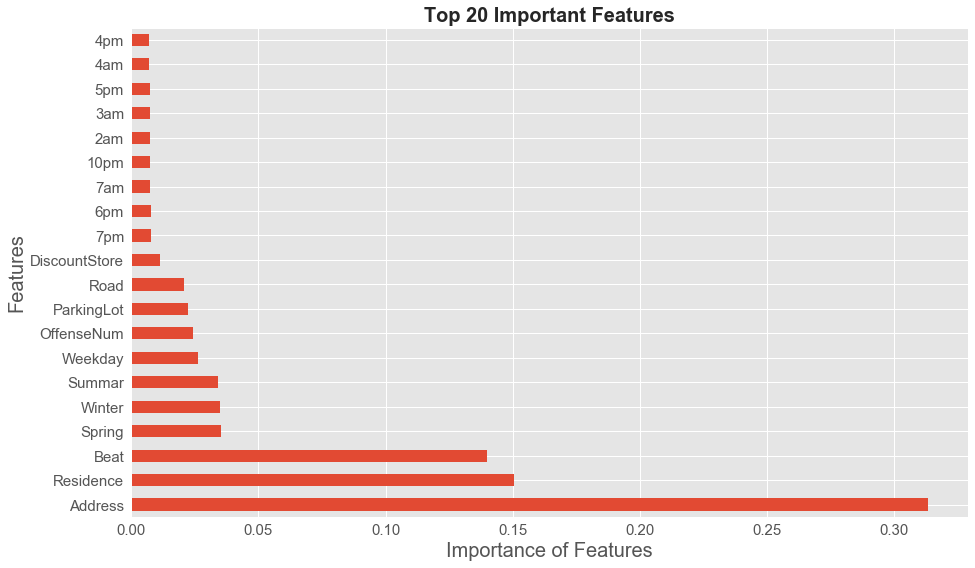

In [31]:
index=X.columns


f= pd.DataFrame(clf_gini.feature_importances_, index=index)
f=f.sort_values(by=0,ascending=False)
#len(f) 47
featuretop20=f[:20]
#featuretop20.index
idxdict={'P_20':'Residence','S_spr':'Spring','S_win':'Winter','S_sum':'Summar','W_Y':'Weekday','P_18':'ParkingLot',
        'P_13':'Road','P_8':'DiscountStore','H_7pm':'7pm','H_6pm':'6pm','H_7am':'7am','H_10pm':'10pm', 'H_2am':'2am', 
         'H_3am':'3am', 'H_5pm':'5pm', 'H_4am':'4am', 'H_4pm':'4pm'}
featuretop20=featuretop20.rename(index=idxdict)

featuretop20.plot(kind='barh',rot=0,legend=False,figsize=(15,9),fontsize=15)
plt.xlabel('Importance of Features',fontsize=20)
plt.ylabel('Features',fontsize=20)
plt.title('Top 20 Important Features',fontsize=20,fontweight='bold')

### Try again but remove 'Address' and onehotencode 'Beat' 

As is shown, 'Address', 'Beat' takes a large portion perhaps due to improper label encoding. Let's use the same classifier but on a new dataset where 'Address' is dropped (should be correlated with 'Beat', both revealing location information) and 'Beat' is onehotencoded.

In [27]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier


#X = X_dropAdd.values
#y = crimes_data.values[:,0]
# # default is 75% / 25% train-test split
X_train, X_test, y_train, y_test = train_test_split(X_dropAdd, y, random_state=0)


# Creating the classifier object
clf_gini = DecisionTreeClassifier(criterion = "gini",
            random_state = 0,max_depth=30, min_samples_leaf=3)
 
# Performing training
clf_object=clf_gini.fit(X_train, y_train)

# Prediction using gini
y_pred_gini = clf_object.predict(X_test)
dtginidropAdd=accuracy_score(y_test,y_pred_gini)
print(dtginidropAdd)

0.5980766845018228


In [28]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gini))
print ("Accuracy : ", accuracy_score(y_test,y_pred_gini)*100)
print("Report :\n", classification_report(y_test, y_pred_gini))


Confusion Matrix:
 [[  2566    231   5145      0      8    326  12301]
 [   654    385   2641      0      1    260  21443]
 [   467     73  29007      1      0    109  15601]
 [    28      3    100      0      0     12    299]
 [    65      8    629      0      2     24   1002]
 [   474    147   2140      2      2    758  15796]
 [  1002    484  18208      1     18    728 116730]]
Accuracy :  59.807668450182284
Report :
                    precision    recall  f1-score   support

AggravatedAssault       0.49      0.12      0.20     20577
        AutoTheft       0.29      0.02      0.03     25384
         Burglary       0.50      0.64      0.56     45258
           Murder       0.00      0.00      0.00       442
             Rape       0.06      0.00      0.00      1730
          Robbery       0.34      0.04      0.07     19319
            Theft       0.64      0.85      0.73    137171

      avg / total       0.54      0.60      0.53    249881



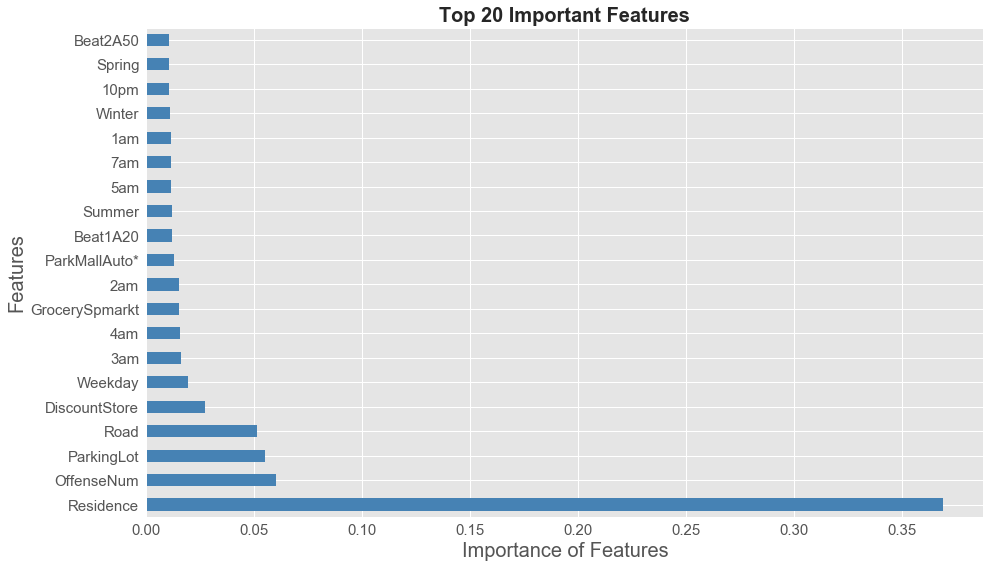

In [35]:
index=X_dropAdd.columns


f= pd.DataFrame(clf_gini.feature_importances_, index=index)
f=f.sort_values(by=0,ascending=False)
ftop20=f[:20]
idx_old=ftop20.index
idx_new=['Residence','OffenseNum','ParkingLot','Road','DiscountStore','Weekday','3am','4am','GrocerySpmarkt',
        '2am','ParkMallAuto*','Beat1A20','Summer','5am','7am','1am','Winter','10pm','Spring','Beat2A50']
idx_dict=dict(zip(idx_old,idx_new))
ftop20=ftop20.rename(index=idx_dict)


ftop20.plot(kind='barh',rot=0,legend=False,figsize=(15,9),fontsize=15,color='steelblue')
plt.xlabel('Importance of Features',fontsize=20)
plt.ylabel('Features',fontsize=20)
plt.title('Top 20 Important Features',fontsize=20,fontweight='bold');



Now the feature-importance makes more sense. However, accuracy, precision...still low. What else can we do to improve the model? Remember, we removed 'Address'. Perhaps it helps if we can convert it into coordinates and use coordinates as new features.

### Decidion tree, criterion = "entropy"

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X_dropAdd, y, random_state=0)


# Creating the classifier object
clf_entropy = DecisionTreeClassifier(criterion = "entropy",
            random_state=0,max_depth=30, min_samples_leaf=3)
 
# Performing training
clf_object=clf_entropy.fit(X_train, y_train)

# Prediction using gini
y_pred_entropy = clf_object.predict(X_test)
#cal_accuracy(y_test, y_pred_gini)
print ("Accuracy : ", accuracy_score(y_test,y_pred_entropy)*100)

Accuracy :  59.670002921390584


In [56]:
print("Confusion Matrix: ", confusion_matrix(y_test, y_pred_entropy))
print ("Accuracy : ", accuracy_score(y_test,y_pred_entropy)*100)
print("Report : ", classification_report(y_test, y_pred_entropy))

Confusion Matrix:  [[  2610    220   5304      0      8    332  12103]
 [   711    358   2675      0      0    255  21385]
 [   477     89  29142      0      2     91  15457]
 [    32      3    102      0      1     15    289]
 [    68      9    648      0      2     27    976]
 [   487    140   2170      3      3    741  15775]
 [  1068    525  18559      1     16    751 116251]]
Accuracy :  59.670002921390584
Report :                     precision    recall  f1-score   support

AggravatedAssault       0.48      0.13      0.20     20577
        AutoTheft       0.27      0.01      0.03     25384
         Burglary       0.50      0.64      0.56     45258
           Murder       0.00      0.00      0.00       442
             Rape       0.06      0.00      0.00      1730
          Robbery       0.33      0.04      0.07     19319
            Theft       0.64      0.85      0.73    137171

      avg / total       0.53      0.60      0.53    249881



### Visualize confusion matrix

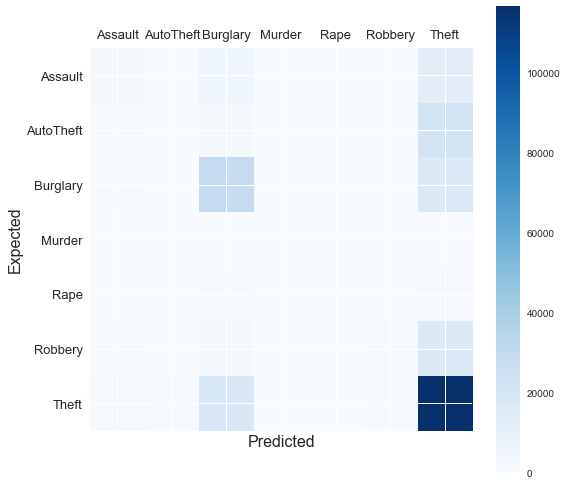

In [57]:
#y_code= crimes_data.iloc[:,0].cat.codes
#dict(zip(y,y_code))

conf_mat=confusion_matrix(y_test, y_pred_gini)
labels = ['Assault', 'AutoTheft', 'Burglary', 'Murder', 'Rape', 'Robbery','Theft']
fig = plt.figure(figsize=(60,60))
ax = fig.add_subplot(666)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels,fontsize=13)
ax.set_yticklabels([''] + labels,fontsize=13)
plt.xlabel('Predicted',fontsize=16)
plt.ylabel('Expected',fontsize=16)

plt.show()


Due to its highly unbalanced classification, the majority class 'Theft' has most correct predictions. 'Burglary' ranks the 2nd with high prediction rate. Another intereting respect from the plot is that crimes like 'AutoTheft', 'Burglary' have higher probability to be mistaken as 'Theft' than property crimes like 'Assault', 'Murder', 'Rape', 'Robbery'.

## A summary

In [38]:
acc=[54.89,57.72,52.86,59.81]
pre=[0.30,0.51,0.52,0.64]
rec=[0.55,0.58,0.53,0.85]
f1=[0.39,0.52,0.52,0.73]
sumry_tab=pd.DataFrame(list(zip(acc,pre,rec,f1)),index=['Dummy','KNN','DTree','DT_rmAdres'],
             columns=['accuray','precision','recall','f1'])
sumry_tab['perct_change']=round((sumry_tab.iloc[:,0]/sumry_tab.iloc[0,0]-1)*100,1)
sumry_tab.index.name='Classifier'
sumry_tab

,accuray,precision,recall,f1,perct_change
Classifier,,,,,
Dummy,54.89,0.30,0.55,0.39,0.0
KNN,57.72,0.51,0.58,0.52,5.2
DTree,52.86,0.52,0.53,0.52,-3.7
DT_rmAdres,59.81,0.64,0.85,0.73,9.0


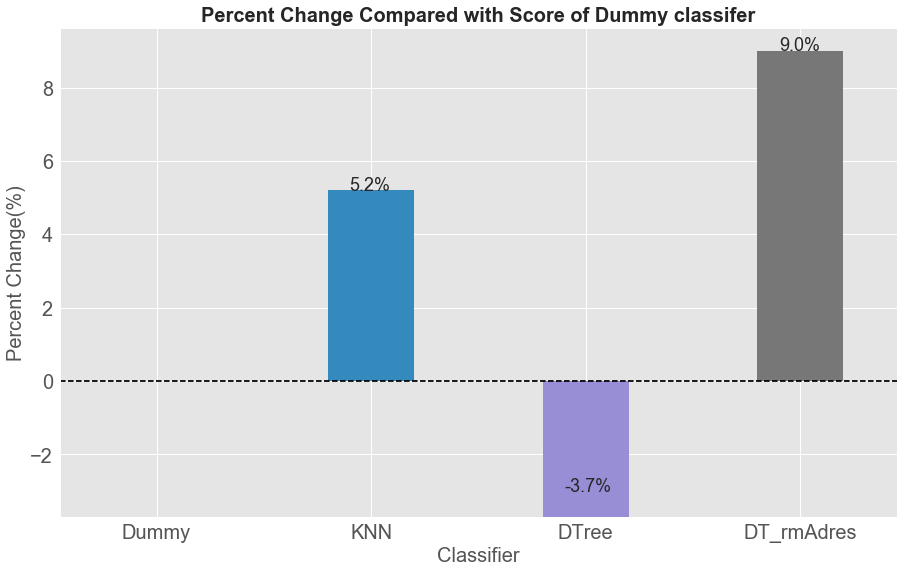

In [41]:
ax1=sumry_tab.perct_change.plot(kind='bar',rot=0,width=0.4,figsize=(15,9),fontsize=20)

ax1.axhline(0,color='black',linestyle='--')

ax1.text(0.9,5.2,str(sumry_tab.perct_change[1])+'%',fontsize=18)
ax1.text(1.9,-3,str(sumry_tab.perct_change[2])+'%',fontsize=18)
ax1.text(2.9,9,str(sumry_tab.perct_change[3])+'%',fontsize=18)


plt.xlabel('Classifier',fontsize=20)
plt.ylabel('Percent Change(%)',fontsize=20)
plt.title('Percent Change Compared with Score of Dummy classifer',fontsize=20,fontweight='bold');



This plot compares accuracy score between classifiers. If we label encode 'Beat' and 'Address' and one hot encode other categorical features, knn got a 5.2% increase in accuracy compared to dummy classifier; Decision tree even has poorer accuracy than dummy classifier. It assigns large weight on 'numeric' features in feature selection process. If we remove 'Addres' and one hot encode other categorical features, knn runs too slow. Decision tree works much better in the sense of gaining 9.0% increase in accuracy compared to dummy classifier.

# 'Theft' or not?
Since 'Theft' takes quite large portion in crimes, let's relabel the crime as 'Y' if it is 'Theft' otherwise label it as 'N'.

In [29]:
# Relabel the target
ctype=crimes.OffenseType.unique().tolist()
cdict={i:'Y' if i=='Theft' else 'N' for i in ctype}

c_copy=crimes.copy()
c_copy['TheftYN']=c_copy.OffenseType.map(cdict)
y_theft=c_copy['TheftYN']
theft_no_count=y_theft.value_counts(normalize=True)



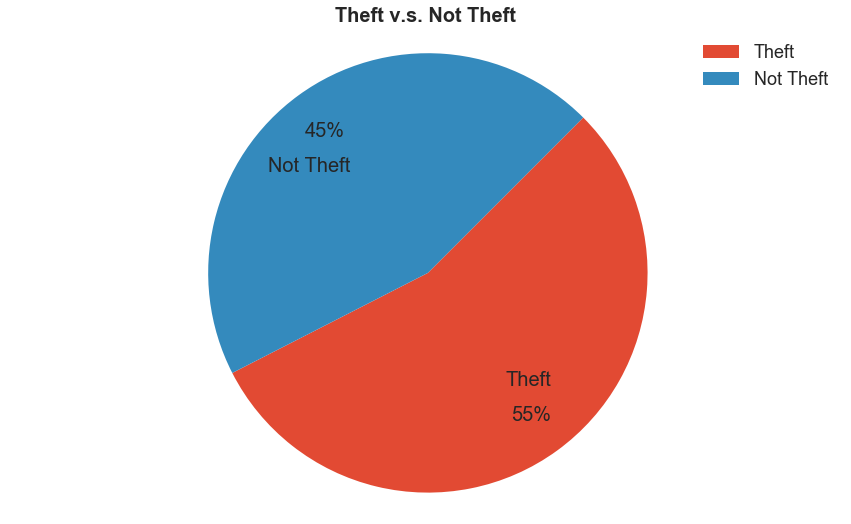

In [30]:
rcParams['font.size'] = 20.0

fig, ax = plt.subplots(figsize=(15,9))
lab=['Theft','Not Theft']
patches, texts, autotexts=ax.pie(theft_no_count, startangle=45, shadow=False,labels=lab,
                labeldistance=0.6, autopct='%1.f%%',pctdistance=0.8,counterclock=False)#autopct='%1.1f%%'
#set label size
[ _.set_fontsize(20) for _ in texts ]

ax.legend(loc='best',fontsize=18)
ax.set_title("Theft v.s. Not Theft",fontweight="bold", size=20)
ax.axis('equal');



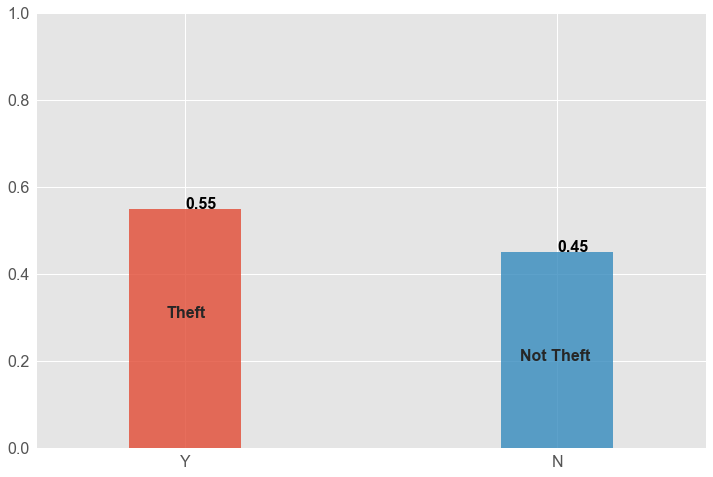

In [63]:
theft_no_count=y_theft.value_counts(normalize=True)
ax=theft_no_count.plot('bar',ylim=(0,1),rot=0,figsize=(12,8),width=0.3,fontsize=16,alpha=0.8)

for i, v in enumerate(theft_no_count):
    ax.text( i,v , round(v,2), color='black', fontweight='bold',fontsize=16);

ax.text(-0.05, 0.3, 'Theft', fontweight='bold',fontsize=16)
ax.text(0.9, 0.2, 'Not Theft', fontweight='bold',fontsize=16);

## Dummy classifier

In [55]:
from sklearn.model_selection import train_test_split

# default is 75% / 25% train-test split
X_train, X_test, y_train, y_test = train_test_split(X_dropAdd, y_theft, random_state=0)
from sklearn.dummy import DummyClassifier

dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)
y_dummy_predictions = dummy_majority.predict(X_test)

y_dummy_predictions


array(['Y', 'Y', 'Y', ..., 'Y', 'Y', 'Y'], dtype='<U1')

In [56]:
dumtheftno=dummy_majority.score(X_test, y_test)
print(dumtheftno)

0.5489452979618298


## Decision tree, criterion = 'gini'

In [33]:
from sklearn.tree import DecisionTreeClassifier


# Creating the classifier object
clf_gini = DecisionTreeClassifier(criterion = "gini",
            random_state = 0,max_depth=30, min_samples_leaf=3)
 
# Performing training
clf_object=clf_gini.fit(X_train, y_train)

# Prediction using gini
y_pred_gini = clf_object.predict(X_test)
dttheftscoregini=accuracy_score(y_test,y_pred_gini)
print ("Accuracy : ", accuracy_score(y_test,y_pred_gini)*100)

Accuracy :  68.36133999783898


In [69]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gini))
print("Report :\n", classification_report(y_test, y_pred_gini))

Confusion Matrix:
 [[73837 38873]
 [40186 96985]]
Report :
              precision    recall  f1-score   support

          N       0.65      0.66      0.65    112710
          Y       0.71      0.71      0.71    137171

avg / total       0.68      0.68      0.68    249881



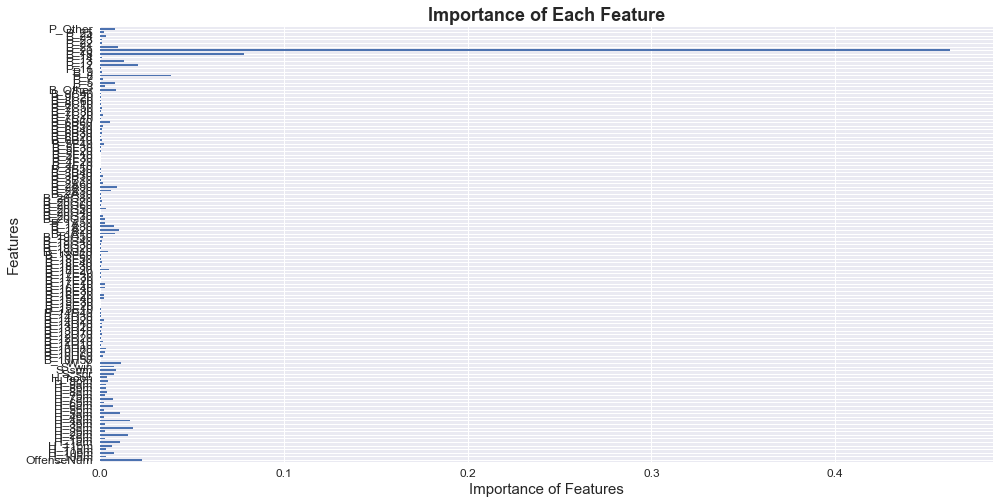

In [77]:
# index=X_dropAdd.columns
# f= pd.DataFrame(clf_gini.feature_importances_, index=index)
# f.sort_values(by=0,ascending=False)

# f.plot(kind='barh',legend=False,figsize=(16,8),fontsize=12)
# plt.xlabel('Importance of Features',fontsize=15)
# plt.ylabel('Features',fontsize=15)
# plt.title('Importance of Each Feature',fontsize=18,fontweight='bold')
# plt.show()

## Decision tree, criterion = 'entropy'

In [70]:
from sklearn.tree import DecisionTreeClassifier


# Creating the classifier object
clf_entropy = DecisionTreeClassifier(criterion = "entropy",
            random_state = 0,max_depth=30, min_samples_leaf=3)
 
# Performing training
clf_object=clf_entropy.fit(X_train, y_train)

# Prediction using gini
y_pred_entropy = clf_object.predict(X_test)
dttheftscoreentr=accuracy_score(y_test,y_pred_gini)
print ("Accuracy : ", accuracy_score(y_test,y_pred_entropy)*100)

Accuracy :  68.40135904690634


In [71]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_entropy))
print("Report :\n", classification_report(y_test, y_pred_entropy))

Confusion Matrix:
 [[73692 39018]
 [39941 97230]]
Report :
              precision    recall  f1-score   support

          N       0.65      0.65      0.65    112710
          Y       0.71      0.71      0.71    137171

avg / total       0.68      0.68      0.68    249881



## Logistic regression

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

logreg=LogisticRegression()
logreg.fit(X_train,y_train)
y_pred_logreg=logreg.predict(X_test)

print ("Accuracy : ", accuracy_score(y_test,y_pred_logreg)*100)

Accuracy :  68.27249770890944


In [58]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_logreg))
print("Report :\n", classification_report(y_test,y_pred_logreg))

Confusion Matrix:
 [[ 69358  43352]
 [ 35929 101242]]
Report :
              precision    recall  f1-score   support

          N       0.66      0.62      0.64    112710
          Y       0.70      0.74      0.72    137171

avg / total       0.68      0.68      0.68    249881



In [60]:
y_pred_prob=logreg.predict_proba(X_test)[:,1]
y_pred_prob

array([0.7477793 , 0.72573562, 0.56884144, ..., 0.37528885, 0.65963087,
       0.23017531])

In [71]:
y_tests=np.where(y_test=='N',0, 1)

In [73]:
print ("AUC score : ", roc_auc_score(y_tests,y_pred_prob))

AUC score :  0.7420957571632989


## A summary

In [120]:
acc=[0.55,0.58,0.53,0.60,0.55,0.68,0.68]
pre=[0.30,0.51,0.52,0.64,0.30,0.68,0.68]
rec=[0.55,0.58,0.53,0.85,0.55,0.68,0.68]
f1=[0.39,0.52,0.52,0.73,0.39,0.68,0.68]
sumry_tab=pd.DataFrame(list(zip(acc,pre,rec,f1)),index=['Dummy','KNN','DTree','DT_rmAdres','Dummy_theft','DT_theft','LogReg_theft'],
             columns=['accuray','precision','recall','f1'])
sumry_tab['perct_change']=round((sumry_tab.iloc[:,0]/sumry_tab.iloc[0,0]-1)*100,1)
sumry_tab.index.name='Classifier'
#sumry_tab.to_csv('sumry_tab.csv',index=True,header=True)
sumry_tab



,accuray,precision,recall,f1,perct_change
Classifier,,,,,
Dummy,0.55,0.30,0.55,0.39,0.0
KNN,0.58,0.51,0.58,0.52,5.5
DTree,0.53,0.52,0.53,0.52,-3.6
DT_rmAdres,0.60,0.64,0.85,0.73,9.1
Dummy_theft,0.55,0.30,0.55,0.39,0.0
DT_theft,0.68,0.68,0.68,0.68,23.6
LogReg_theft,0.68,0.68,0.68,0.68,23.6


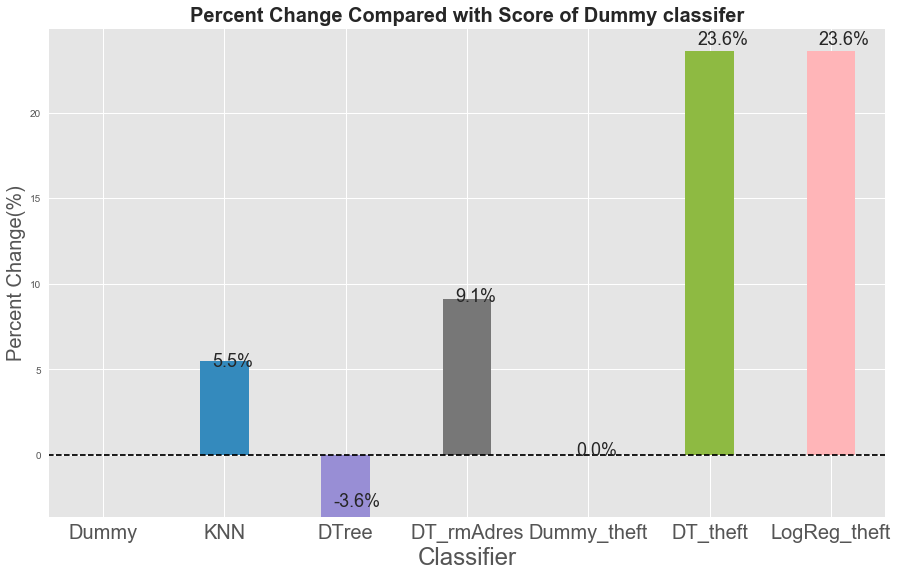

In [121]:
ax1=sumry_tab.perct_change.plot(kind='bar',rot=0,width=0.4,figsize=(15,9))

ax1.axhline(0,color='black',linestyle='--')

ax1.text(0.9,5.2,str(sumry_tab.perct_change[1])+'%',fontsize=18)
ax1.text(1.9,-3,str(sumry_tab.perct_change[2])+'%',fontsize=18)
ax1.text(2.9,9,str(sumry_tab.perct_change[3])+'%',fontsize=18)
ax1.text(3.9,0,str(sumry_tab.perct_change[4])+'%',fontsize=18)
ax1.text(4.9,24,str(sumry_tab.perct_change[5])+'%',fontsize=18)
ax1.text(5.9,24,str(sumry_tab.perct_change[6])+'%',fontsize=18)



plt.ylabel('Percent Change(%)',fontsize=20)
plt.title('Percent Change Compared with Score of Dummy classifer',fontsize=20,fontweight='bold');
#plt.savefig('figs/CompareClassifier')


The bar chart shows that in predicting 'Theft' or 'Not Theft', decision tree classifier and logistic regression  each enhances accuracy by 23.6% compared to that of dummy classifier.

# Violent or property crime?

In [80]:
ctype=crimes.OffenseType.unique().tolist()
cdict={i:'P' if i in ['Theft', 'AutoTheft', 'Burglary'] else 'V' for i in ctype}

c_copy=crimes.copy()
c_copy.OffenseType=c_copy.OffenseType.map(cdict)

y_property=c_copy.OffenseType
c_copy.head()

,Hour,OffenseType,Beat,Premise,BlockRange,StreetName,Type,Suffix,OffenseNum
Date,,,,,,,,,
2010-01-01,2,P,7C20,13,3100-3199,COLLINGSWORTH,-,-,1
2010-01-01,2,V,20G70,18,1900-1999,WESTMEAD,DR,-,1
2010-01-01,9,V,4F30,13,1700-1799,BRITTMOORE,RD,-,1
2010-01-01,10,V,20G10,18,2900-2999,WEST SAM HOUSTON,PKWY,S,1
2010-01-01,14,V,20G80,8,1000-1099,WEST OAKS MALL,-,-,1


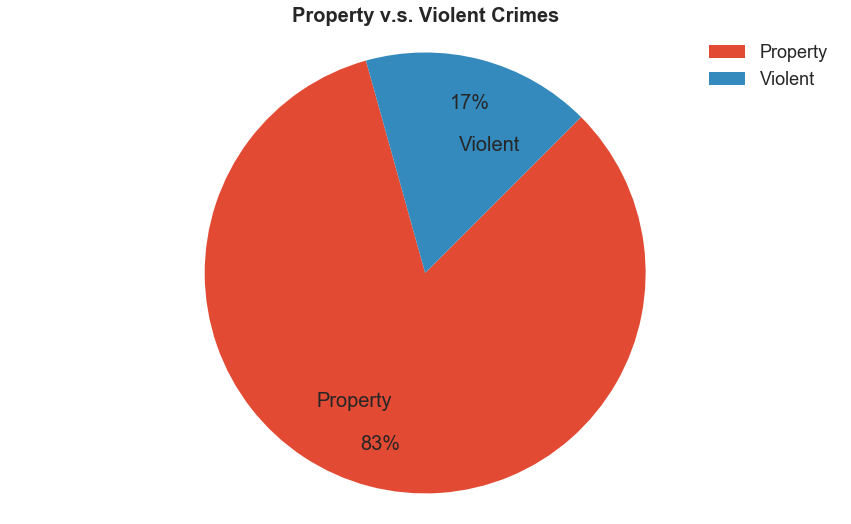

In [49]:
rcParams['font.size'] = 20.0

prop_vio_count=y_property.value_counts(normalize=True)


fig, ax = plt.subplots(figsize=(15,9))
lab=['Property','Violent']
patches, texts, autotexts=ax.pie(prop_vio_count, startangle=45, shadow=False,labels=lab,
                labeldistance=0.6, autopct='%1.f%%',pctdistance=0.8,counterclock=False)#autopct='%1.1f%%'
#set label size
[ _.set_fontsize(20) for _ in texts ]

ax.legend(loc='best',fontsize=18)
ax.set_title("Property v.s. Violent Crimes",fontweight="bold", size=20)
ax.axis('equal');

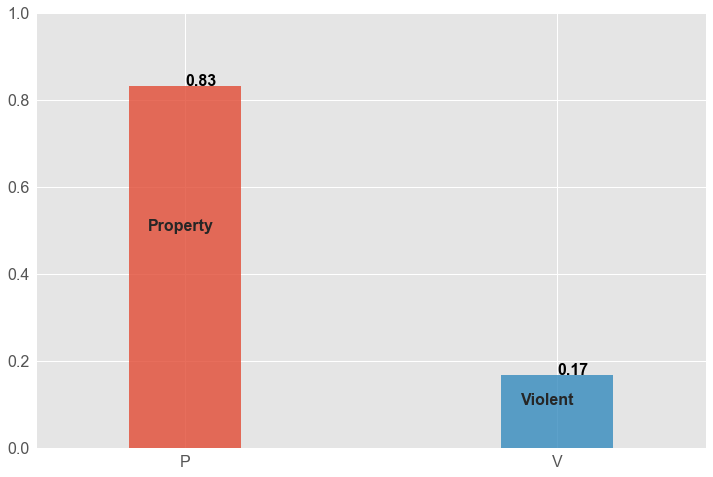

In [51]:
prop_vio_count=y_property.value_counts(normalize=True)
ax=prop_vio_count.plot('bar',ylim=(0,1),rot=0,figsize=(12,8),width=0.3,fontsize=16,alpha=0.8)

for i, v in enumerate(prop_vio_count):
    ax.text( i,v , round(v,2), color='black', fontweight='bold',fontsize=16);

ax.text(0-0.1, 0.5, 'Property', fontweight='bold',fontsize=16)
ax.text(1-0.1, 0.1, 'Violent', fontweight='bold',fontsize=16);

Although it is still an unbalanced classification, but now it's binary!

## Dummy classifier

In [87]:
from sklearn.model_selection import train_test_split

# default is 75% / 25% train-test split
X_train, X_test, y_train, y_test = train_test_split(X_dropAdd, y_property, random_state=0)
from sklearn.dummy import DummyClassifier

dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)
y_dummy_predictions = dummy_majority.predict(X_test)

y_dummy_predictions
dumporvscore=dummy_majority.score(X_test, y_test)
print(dumporvscore)

0.8316478643834465


In [48]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_dummy_predictions))
print("Report: \n", classification_report(y_test, y_dummy_predictions))



Confusion Matrix:
 [[207813      0]
 [ 42068      0]]
Report: 
              precision    recall  f1-score   support

          P       0.83      1.00      0.91    207813
          V       0.00      0.00      0.00     42068

avg / total       0.69      0.83      0.76    249881



/Users/phyhouhou/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

logreg=LogisticRegression()
logreg.fit(X_train,y_train)
y_pred_logreg=logreg.predict(X_test)

print ("Accuracy : ", accuracy_score(y_test,y_pred_logreg)*100)




Accuracy :  84.1100363773156


In [83]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_logreg))
print("Report :\n", classification_report(y_test,y_pred_logreg))


Confusion Matrix:
 [[204639   3174]
 [ 36533   5535]]
Report :
              precision    recall  f1-score   support

          P       0.85      0.98      0.91    207813
          V       0.64      0.13      0.22     42068

avg / total       0.81      0.84      0.79    249881



In [91]:
y_testt=np.where(y_test=='P',1,0)

y_pred_prob=logreg.predict_proba(X_test)[:,0]
y_pred_prob

print ("AUC score : ", roc_auc_score(y_testt,y_pred_prob))

AUC score :  0.741620920885904


## Decision tree

In [37]:
from sklearn.tree import DecisionTreeClassifier


# Creating the classifier object
clf_gini = DecisionTreeClassifier(criterion = "gini",
            random_state = 0,max_depth=30, min_samples_leaf=3)
 
# Performing training
clf_object=clf_gini.fit(X_train, y_train)

# Prediction using gini
y_pred_gini = clf_object.predict(X_test)
dtPorVscore=accuracy_score(y_test,y_pred_gini)
print ("Accuracy : ", accuracy_score(y_test,y_pred_gini)*100)

Accuracy :  83.81709693814256


In [38]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gini))
print("Report: \n", classification_report(y_test, y_pred_gini))


Confusion Matrix:
 [[202129   5684]
 [ 34754   7314]]
Report: 
              precision    recall  f1-score   support

          P       0.85      0.97      0.91    207813
          V       0.56      0.17      0.27     42068

avg / total       0.80      0.84      0.80    249881



## Resampling
In order to balance the unbalanced datasets, we can either remove samples from the majority class(under-sampling) and/or add more examples from the minority class(over-sampling). We use the Python library imbalanced-learn to perform resampling.

### Under sampling

In [39]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(return_indices=True)
X_rus, y_rus, id_rus = rus.fit_sample(X_dropAdd, y_property)

print('Removed indexes:', id_rus)
len(id_rus)

Removed indexes: [ 84031 252471 635584 ... 999516 999517 999518]


336402

#### Dummy classifier

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, random_state=0)


from sklearn.dummy import DummyClassifier

dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)
y_dummy_predictions = dummy_majority.predict(X_test)

y_dummy_predictions
dumrusscore=dummy_majority.score(X_test, y_test)
print(dumrusscore)

0.4965814913021248


In [124]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_dummy_predictions))
print("Report: \n", classification_report(y_test, y_dummy_predictions))

Confusion Matrix:
 [[    0 42338]
 [    0 41763]]
Report: 
              precision    recall  f1-score   support

          P       0.00      0.00      0.00     42338
          V       0.50      1.00      0.66     41763

avg / total       0.25      0.50      0.33     84101



/Users/phyhouhou/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Decision tree

In [93]:
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, random_state=0)


# Creating the classifier object
clf_gini = DecisionTreeClassifier(criterion = "gini",
            random_state = 0,max_depth=30, min_samples_leaf=5)
 
# Performing training
clf_object=clf_gini.fit(X_train, y_train)

# Prediction using gini
y_pred_gini = clf_object.predict(X_test)
dtrusscore=accuracy_score(y_test,y_pred_gini)
print ("Accuracy : ", accuracy_score(y_test,y_pred_gini)*100)

Accuracy :  66.24653690205824


In [42]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gini))
print("Report: \n", classification_report(y_test, y_pred_gini))

Confusion Matrix:
 [[31687 10651]
 [17736 24027]]
Report: 
              precision    recall  f1-score   support

          P       0.64      0.75      0.69     42338
          V       0.69      0.58      0.63     41763

avg / total       0.67      0.66      0.66     84101



#### Logistic regression

In [94]:
logreg=LogisticRegression()
logreg.fit(X_train,y_train)
y_pred_logreg=logreg.predict(X_test)

print ("Accuracy : ", accuracy_score(y_test,y_pred_logreg)*100)


print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_logreg))
print("Report :\n", classification_report(y_test,y_pred_logreg))



Accuracy :  67.68766126443205
Confusion Matrix:
 [[28936 13402]
 [13773 27990]]
Report :
              precision    recall  f1-score   support

          P       0.68      0.68      0.68     42338
          V       0.68      0.67      0.67     41763

avg / total       0.68      0.68      0.68     84101



### Over sampling

In [43]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X_dropAdd, y_property)

print(X_ros.shape[0] - X.shape[0], 'new random picked points')


663119 new random picked points


#### Dummy classifier

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, random_state=0)


from sklearn.dummy import DummyClassifier

dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)
y_dummy_predictions = dummy_majority.predict(X_test)

y_dummy_predictions
dumrosscore=dummy_majority.score(X_test, y_test)
print(dumrosscore)

0.499494779386999


In [126]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_dummy_predictions))
print("Report: \n", classification_report(y_test, y_dummy_predictions))

Confusion Matrix:
 [[207620      0]
 [208040      0]]
Report: 
              precision    recall  f1-score   support

          P       0.50      1.00      0.67    207620
          V       0.00      0.00      0.00    208040

avg / total       0.25      0.50      0.33    415660



/Users/phyhouhou/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Decision tree

In [45]:
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, random_state=0)


# Creating the classifier object
clf_gini = DecisionTreeClassifier(criterion = "gini",
            random_state = 0,max_depth=30, min_samples_leaf=3)
 
# Performing training
clf_object=clf_gini.fit(X_train, y_train)

# Prediction using gini
y_pred_gini = clf_object.predict(X_test)
dtrosscore=accuracy_score(y_test,y_pred_gini)
print ("Accuracy : ", accuracy_score(y_test,y_pred_gini)*100)

Accuracy :  67.8547370447


In [46]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gini))
print("Report: \n", classification_report(y_test, y_pred_gini))

Confusion Matrix:
 [[157747  49873]
 [ 83742 124298]]
Report: 
              precision    recall  f1-score   support

          P       0.65      0.76      0.70    207620
          V       0.71      0.60      0.65    208040

avg / total       0.68      0.68      0.68    415660



#### Logistic regression

In [96]:
logreg=LogisticRegression()
logreg.fit(X_train,y_train)
y_pred_logreg=logreg.predict(X_test)

print ("Accuracy : ", accuracy_score(y_test,y_pred_logreg)*100)


print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_logreg))
print("Report :\n", classification_report(y_test,y_pred_logreg))




Accuracy :  67.82634845787422
Confusion Matrix:
 [[142688  64932]
 [ 68801 139239]]
Report :
              precision    recall  f1-score   support

          P       0.67      0.69      0.68    207620
          V       0.68      0.67      0.68    208040

avg / total       0.68      0.68      0.68    415660



## A summary

In [97]:
acc=[0.83,0.84,0.84,0.50,0.66,0.68,0.50,0.68,0.68]
pre=[0.69,0.80,0.81,0.25,0.67,0.68,0.25,0.68,0.68]
rec=[0.83,0.84,0.84,0.50,0.66,0.68,0.50,0.68,0.68]
f1=[0.76,0.80,0.79,0.33,0.66,0.68,0.33,0.68,0.68]
sumry_tab=pd.DataFrame(list(zip(acc,pre,rec,f1)),index=['Dmy_PorV','DT_PorV','LogReg_PorV',
                        'Dmy_rus','DT_rus','LogReg_rus','Dmy_ros','DT_ros','LogReg_ros'],
             columns=['accuray','precision','recall','f1'])
sumry_tab['perct_change']=round((sumry_tab.iloc[:,0]/sumry_tab.iloc[0,0]-1)*100,1)
sumry_tab.index.name='Classifier'
#sumry_tab.to_csv('sumry_tab_PorV.csv',index=True,header=True)
sumry_tab

,accuray,precision,recall,f1,perct_change
Classifier,,,,,
Dmy_PorV,0.83,0.69,0.83,0.76,0.0
DT_PorV,0.84,0.80,0.84,0.80,1.2
LogReg_PorV,0.84,0.81,0.84,0.79,1.2
Dmy_rus,0.50,0.25,0.50,0.33,-39.8
DT_rus,0.66,0.67,0.66,0.66,-20.5
LogReg_rus,0.68,0.68,0.68,0.68,-18.1
Dmy_ros,0.50,0.25,0.50,0.33,-39.8
DT_ros,0.68,0.68,0.68,0.68,-18.1
LogReg_ros,0.68,0.68,0.68,0.68,-18.1


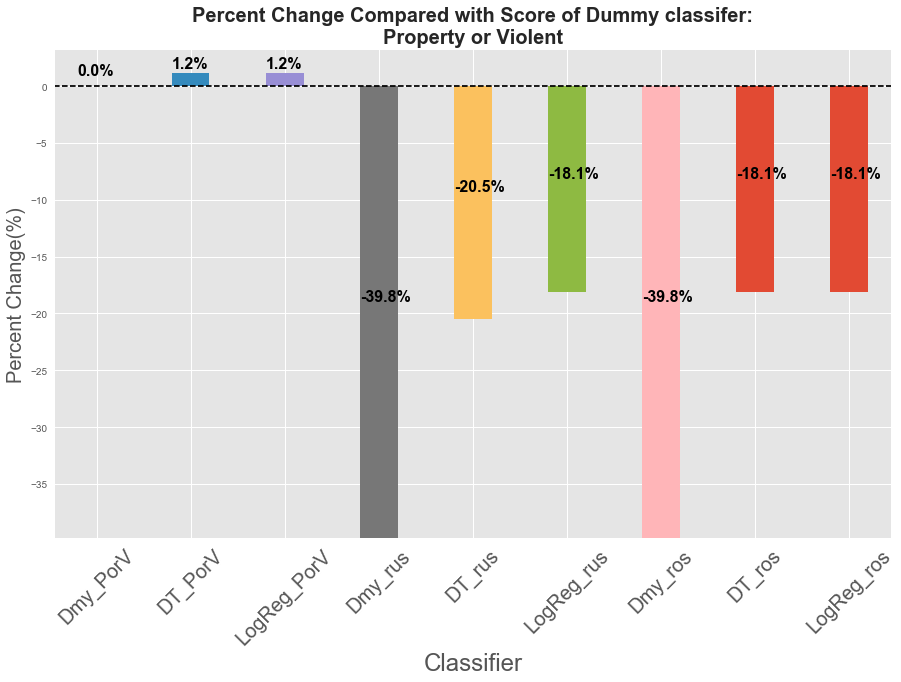

In [119]:
ax1=sumry_tab.perct_change.plot(kind='bar',rot=45,width=0.4,figsize=(15,9))

ax1.axhline(0,color='black',linestyle='--')

for i, v in enumerate(sumry_tab.perct_change):
    ax1.text( i-0.2,v/2+1, str(v)+'%', color='black', fontweight='bold',fontsize=16);



plt.ylabel('Percent Change(%)',fontsize=20)
plt.title('Percent Change Compared with Score of Dummy classifer:\nProperty or Violent',fontsize=20,fontweight='bold');



'Property crime' or 'Violent crime'? This is a binary classification. However, it is highly unbalanced since there are as much as 4 times property crimes as violent crime. If we take the dummy classifer without further steps, we get a high accuracy determined by the portion of majority class. If we take the decision tree classifier, accuracy is slightly enhanced by 1.2%.

What if we try to balance the classes by resampling the data? According to this plot, whether undersampling (indicated by '_rus') or oversampling (indicated by '_ros'), dummy classifer gave poorer accuracy. Even the decision tree method can't reach the accuracy of the dummy classifer without resampling. But metrics other than 'accuracy' is increased in decision tree classifers with resampling.

# What's next?

1. Reduce levels of categorical estimators, i.e., 'Beat', 'Premise'... to less.
2. Convert 'Address' to coordinates
3. Involve more features like information on criminals/ victims, weather, ecomomics by concating other data sets. 